In [1]:
import pandas as pd
from collections import Counter
import numpy as np 
import string
import re
from sklearn.model_selection import train_test_split
from __future__ import print_function
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from xgboost import XGBClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
import collections
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


import nltk
import nltk.data
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pickle


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

In [2]:
total = pd.read_csv('./dataset/preprocessed_dataset.csv',sep=",")

In [3]:
total.shape

(9342, 2)

In [4]:
total.head()

,body,tags
0,write daemon run emb platform need chang defau...,"c,linux,networking"
1,use gdi+ c++ two problem find canvasimg black ...,"canvas,gdi+"
2,write program need determin bit set know rotat...,"assembly,bit-manipulation,mips"
3,consol applic server accept sever connect clie...,"java,events,listener"
4,attempt provid script solut read content file ...,"javascript,html,file-io,sandbox"


[('c#', 70), ('asp.net-mvc', 53), ('python', 40), ('iphone', 34), ('asp.net', 32), ('javascript,jquery', 31), ('jquery', 29), ('javascript', 29), ('c#,.net', 28), ('php', 26), ('sql-server', 23), ('java', 23), ('c++', 19), ('c#,asp.net', 18), ('ruby-on-rails', 18), ('iphone,cocoa-touch', 17), ('mysql', 17), ('html,css', 16), ('vb.net', 16), ('sql', 15)]


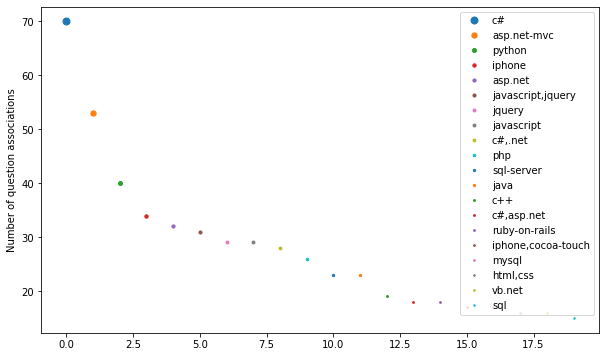

In [5]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]
    area = [i/10 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10,6))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
      plt.plot(i,y[i],marker='o',linestyle='',ms=area[i],label=x[i])   
    plt.legend(numpoints=1)
    plt.show()

tagCount =  collections.Counter(list(total['tags'])).most_common(20)
print(tagCount)
plot_tags(tagCount)

In [6]:
total = total[
        (total.tags == 'c#') | (total.tags == 'asp.net-mvc') | (total.tags == 'python') | (total.tags =='iphone') | 
        (total.tags =='asp.net') | (total.tags == 'javascript,jquery') | (total.tags == 'javascript') | (total.tags == 'c#,.net') | 
        (total.tags == 'php') | (total.tags == 'sql-server') |
        (total.tags == 'java') | (total.tags == 'c++') | (total.tags == 'c#,asp.net') | (total.tags =='ruby-on-rails') | 
        (total.tags == 'iphone,cocoa-touch') | (total.tags == 'mysql') | (total.tags == 'html,css') | (total.tags =='vb.net') | (total.tags =='sql')
        ]

In [7]:
def tokenize(text):
    result = ""
    #print(type(text))
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
             result = result + ' ' + token
    return result

processed_body = total['body'].map(tokenize)

In [8]:
vectorizer = TfidfVectorizer(max_features=10000, use_idf=True)
vectorizer = vectorizer.fit(total['body'])
tf_len = len(vectorizer.vocabulary_)
X = vectorizer.transform(processed_body).astype('float64')

## Multilabel encoding

In [9]:
def extract_tag(text_raw, num=0):
    list_tags = text_raw.split(',')
    try:
        return list_tags[num]
    except:
        return '-'

In [10]:
#Eclatement des tags en colonne
total["tag_0"] = total.tags.apply(extract_tag)
total["tag_1"] = total.tags.apply(extract_tag, args=(1,))
total["tag_2"] = total.tags.apply(extract_tag, args=(2,))
total["tag_3"] = total.tags.apply(extract_tag, args=(3,))
total["tag_4"] = total.tags.apply(extract_tag, args=(4,))
total.head()

,body,tags,tag_0,tag_1,tag_2,tag_3,tag_4
15,design websit tabl less problem take long time...,"html,css",html,css,-,-,-
18,untest need write code correct feel like miss ...,c#,c#,-,-,-,-
33,net object c properti name event event els way...,"c#,.net",c#,.net,-,-,-
53,way check variabl class member standalon speci...,python,python,-,-,-,-
54,differ sql server authent window authent speci...,sql-server,sql-server,-,-,-,-


In [11]:
# create list of list of labels
labels_list = []
for tags in total['tags']:
    t = tags.split(',')
    m = []
    for st in t:
        m.append(st)
    labels_list.append(m)


In [12]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels_list)

## Benchmarking MultiLabel Classifiers

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, random_state=42, test_size=0.2, shuffle=True)

In [14]:
models_list = []
models_name = []
preds_list = []

### Native multi-label classifiers

In [15]:
knnClf = KNeighborsClassifier()
knnClf.fit(X_train, y_train)
knnPreds = knnClf.predict(X_test)
models_name.append('knn')
models_list.append(knnClf)
preds_list.append(knnPreds)

In [16]:
dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(X_train, y_train)
dtPreds = dtClassifier.predict(X_test)
models_name.append('decision tree')
models_list.append(dtClassifier)
preds_list.append(dtPreds)

In [17]:
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(X_train, y_train)
rfPreds = rfClassifier.predict(X_test)
models_name.append('random forest')
models_list.append(rfClassifier)
preds_list.append(rfPreds)

### Problem transformation : use binary classifiers to be used in 1 vs rest approach

In [18]:
bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bagClassifier.fit(X_train, y_train)
bagPreds = bagClassifier.predict(X_test)
models_name.append('bagging classifier')
models_list.append(bagClassifier)
preds_list.append(bagPreds)

In [19]:
boostClassifier = OneVsRestClassifier(GradientBoostingClassifier())
boostClassifier.fit(X_train, y_train)
boostPreds = boostClassifier.predict(X_test)
models_name.append('gradient boosting')
models_list.append(boostClassifier)
preds_list.append(boostPreds)

In [20]:
nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(X_train, y_train)
nbPreds = nbClassifier.predict(X_test)
models_name.append('multinomial nb')
models_list.append(nbClassifier)
preds_list.append(nbPreds)

In [21]:
svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(X_train, y_train)
svmPreds = svmClassifier.predict(X_test)
models_name.append('linear svc')
models_list.append(svmClassifier)
preds_list.append(svmPreds)

## Models performance

In [22]:
def metricsReport(model_name, test_labels, predictions):
    out = []
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    ham_loss = hamming_loss(test_labels, predictions)
    out.append(model_name)
    out.append(micro_f1)
    out.append(ham_loss)    
    
    return out

In [23]:
metrics = []
for i in range(len(models_list)):
    
    out = metricsReport(models_name[i], y_test, preds_list[i])
    
    metrics.append(out)
df = pd.DataFrame(metrics, columns = ['model', 'f1 score', 'hamming loss'])    

In [24]:
df

,model,f1 score,hamming loss
0,knn,0.257669,0.060652
1,decision tree,0.463415,0.066165
2,random forest,0.180556,0.059148
3,bagging classifier,0.445714,0.048622
4,gradient boosting,0.440000,0.056140
5,multinomial nb,0.000000,0.064160
6,linear svc,0.231293,0.056642


Meilleur modèle : bagging classifier

    - f1_score = 0.46
    - hamming loss = 0.048 (1 - accuracy)

### Prediction sur un exemple

In [25]:
def myTokenizer(text):
    '''
    Create tokens from text (English words > 3 letters)
    '''
    def stem_tokens(tokens, stemmer):
        '''
        Stem words in tokens.
        and suppress word < 3 characters
        '''
        stemmed = []
        for item in tokens:
            if re.match('[a-zA-Z0-9]{3,}',item):
                stemmed.append(stemmer.stem(item))
        return stemmed

    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, EnglishStemmer())
    return stems

In [26]:
def predict(post, vectorizer, model):
    pattern = re.compile('[^A-Za-z +]')
    intermediate = re.sub(pattern, ' ', post)
    intermediate = post.lower()

    stop_words = set(stopwords.words('english')) 
    #print(text)
    word_tokens = word_tokenize(intermediate) 
    filtered_text = ' '.join(w for w in word_tokens if not w in stop_words)

    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = EnglishStemmer()
    stemmed = myTokenizer(filtered_text)
    x_input = vectorizer.transform(stemmed).astype('float64')
    tags = model.predict(x_input)
    return tags

In [27]:
post = "Hello, I am developing a new application and I need to create a new table in sql-server database. " \
    "My application is an HTML form and I submit it through a javascript function. How can I do that ? Thanks !"

In [28]:
tags = predict(post,vectorizer,bagClassifier)

In [29]:
all_labels = mlb.inverse_transform(tags)
type(all_labels)
for label in all_labels:
    s = ''.join(label)
    if len(s) != 0:
        print(s)

sql-server
javascript


### Save model

In [30]:
pickle.dump(bagClassifier, open('./models/bagClassifier.obj', 'wb'))

In [31]:
pickle.dump(vectorizer, open('./models/vectorizer.obj', 'wb'))